# Image segmentation using FastAI 

Author: Siti Khotijah

Created on: 7/29/2021

## Introduction

Image segmentation is an application of computer vision wherein we color-code every pixel in an image. Each pixel then represents a particular object in that image. Image segmentation is usually used when we care about edges and regions, when we want to separate important objects from the background. We want to know the specifics of an object and conduct further analysis on it from there on. Think about it in terms of a self driving car. A self driving car will not only want to identify a street, but also know it’s edges or curves in order to make the correct turn. We treat image segmentation as a classification problem, where for every pixel in the image, we try to predict what it is. Is it a bicycle, road line, sidewalk, or a building? In this way we produce a color coded image where every object has the same color.

## Import libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *

## Load Data

Fastai provides a lot of academic datasets under URLs variable. You can see in the image below. In this study, we will untar the URLs.CAMVID

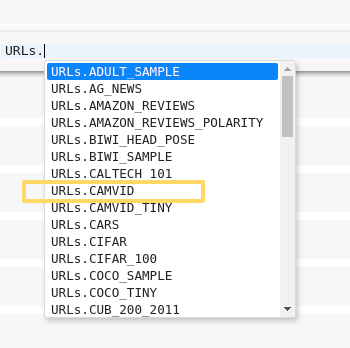

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/labels')]

## Create the path for labels and images folder

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Check the type image files im images folder

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_07830.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_006750.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f03810.png')]

## Grab the labels associated with the images

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0006R0_f02580_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_010140_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f04950_P.png')]

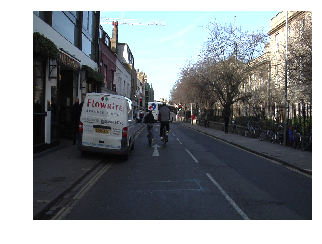

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

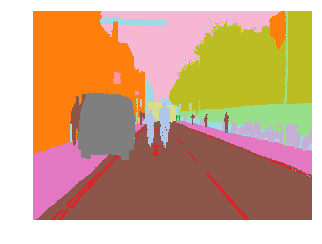

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Creating a data bunch
We are creating data bunch using fastai data block API

### Step-1

In [12]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

* We are using SegmentationItemList because of the type of inputs we are getting.
* ```.from_folder()``` — our image data is present at the specified path.
* ```split_by_fname_file()``` — we want to separate the validation dataset using the file name as validation dataset is provided in the ```valids.txt``` file. We need to provide a valid path to the file.
* ```label_from_func () ``` — We need to create labels for which we can use get_label_image (get Y file name function) we just created. We have a list of class names. Often with stuff like the planet dataset or the pets dataset, we have a string saying this is a pug, or this is cloudy or whatever. In this case, you don’t have every single pixel labelled with an entire string. They’re each marked with just a number, and then there’s a separate file telling you what those numbers mean. So here’s where we get to say to the data block API this is the list of what the numbers mean.

In [13]:
size = src_size//2
bs=8

In [14]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs, num_workers=0)
        .normalize(imagenet_stats))

* Here ```batch size``` is the number of images to be processed at a time. The value may vary like ```8, 16, .., 64,..``` depending upon the GPU configuration.
* ```tfm_y``` — This attribute ensures that what transformation is applied to the input variables, apply the same transformation to output variable as well. It makes a lot of sense while handling image dataset.
* We are taking the size of images half of the original to the size of the masked images to learn fast. ```//2``` does the integer divide as we do not want to have a float number since it represents rows*columns.

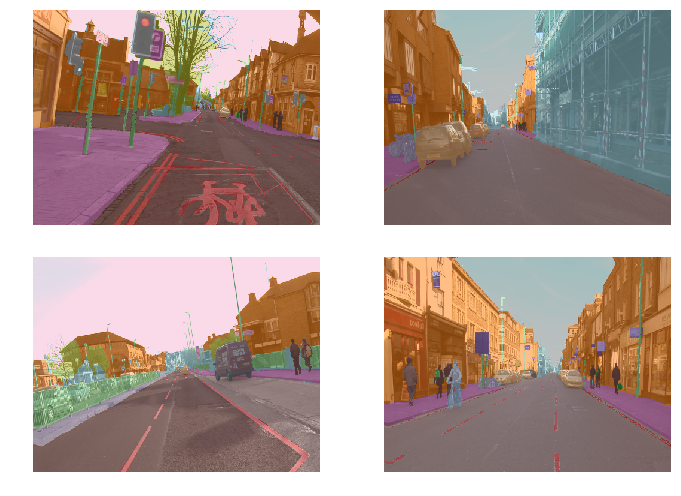

In [15]:
data.show_batch(2, figsize=(10,7))

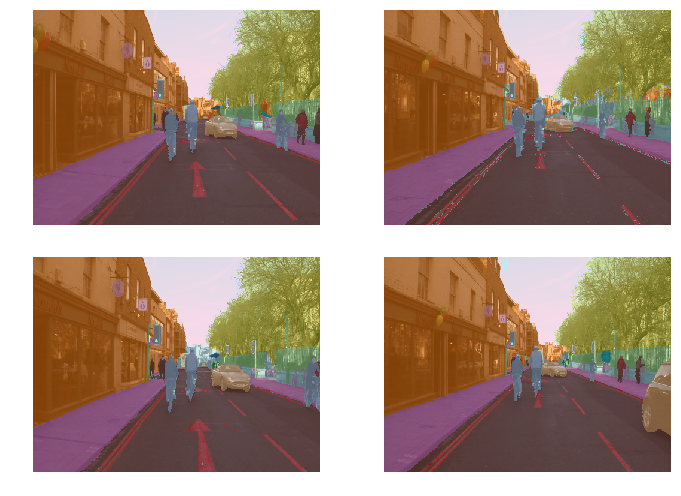

In [16]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [17]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [18]:
metrics=acc_camvid

In [19]:
wd=1e-2

## Training

While training our model, we will be using the U-Net neural network architecture instead of CNN.

### Step-1

In [20]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:04<00:00, 19726290.33it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


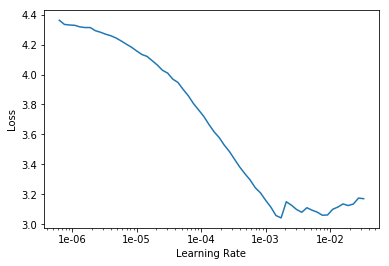

In [21]:
lr_find(learn)
learn.recorder.plot()

In [22]:
# lr = slice(1e-06,1e-03)

In [23]:
learn.fit_one_cycle(10, slice(1e-06,1e-03), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
1,1.426932,0.898506,0.769252,01:44
2,0.912377,0.678587,0.839060,01:41
3,0.737872,0.635518,0.828522,01:39
4,0.662928,0.528261,0.854110,01:40
5,0.594360,0.481911,0.866199,01:40
6,0.572818,0.460054,0.870669,01:40
7,0.530014,0.437723,0.881597,01:41
8,0.557650,0.467273,0.868027,01:40
9,0.502380,0.422436,0.881518,01:40
10,0.424701,0.333702,0.904997,01:41


In [24]:
path = "."

In [25]:
learn.save('stage-1')

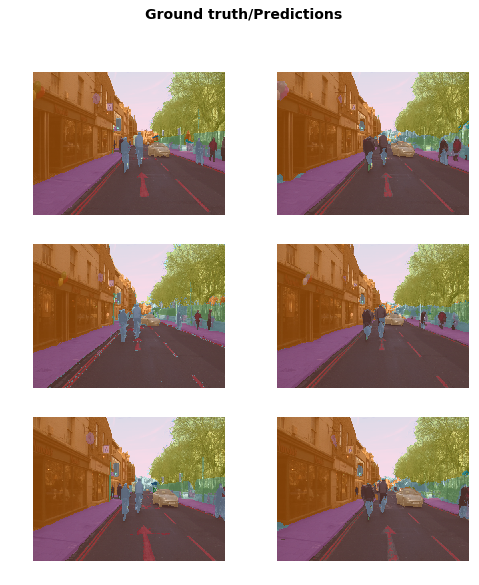

In [26]:
learn.show_results(rows=3, figsize=(8,9))

### Step-2

In [27]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


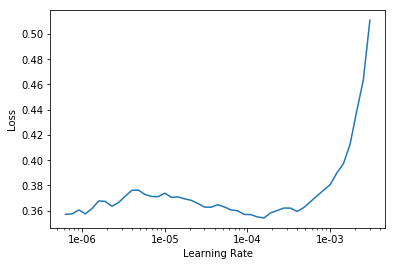

In [28]:
lr_find(learn)
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(12, slice(1e-5,1e-4), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
1,0.367847,0.319621,0.910735,01:42
2,0.360685,0.311039,0.913448,01:41
3,0.350429,0.309229,0.913420,01:41
4,0.351339,0.303437,0.915798,01:41
5,0.341131,0.293847,0.918918,01:40
6,0.331591,0.285554,0.920074,01:42
7,0.321177,0.294524,0.915597,01:41
8,0.314872,0.294906,0.915893,01:41
9,0.301941,0.298376,0.912700,01:42
10,0.294577,0.298364,0.916208,01:41


In [30]:
learn.save('stage-2')

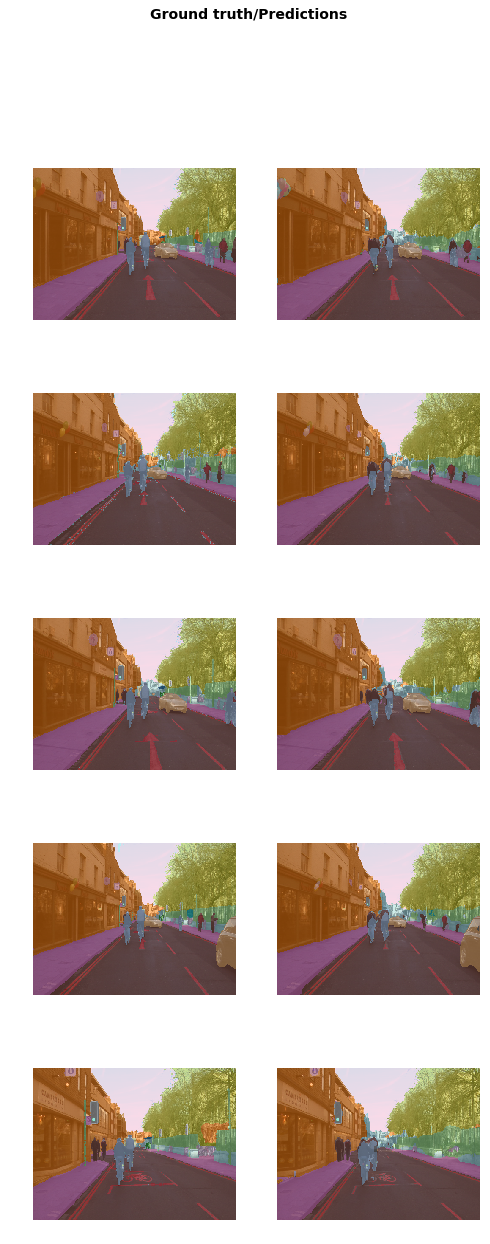

In [31]:
learn.show_results()
